In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 35.4 MB/s eta 0:00:00


H vs (E and S )

Data brute

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.5574 - loss: 102.2601 - val_accuracy: 0.6222 - val_loss: 18.9634
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8377 - loss: 5.1951 - val_accuracy: 0.6667 - val_loss: 27.7277
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9635 - loss: 1.6764 - val_accuracy: 0.6444 - val_loss: 27.6067
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9892 - loss: 0.0242 - val_accuracy: 0.6556 - val_loss: 25.6915
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 6.6467e-08 - val_accuracy: 0.6556 - val_loss: 25.6917
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000 - loss: 2.5409e-08 - val_accuracy: 0.6556 - val_loss: 25.6920
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 1.0000 - loss: 3.1114e-08 - val_accuracy: 0.6556 - val_loss: 25.6925
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 4.9076e-08 - val_accuracy: 0.6556 - val

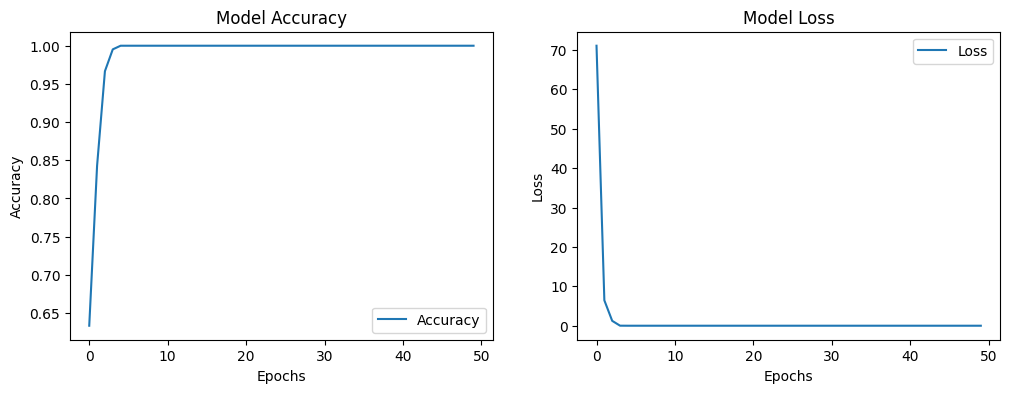

Model saved successfully at /content/drive/MyDrive/Models/Walvet_dec/ANN/Exp4/No_Options.keras ✅


In [3]:
import os
import numpy as np
import pywt  # Wavelet library
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
import time
import matplotlib.pyplot as plt

# Define a function to load the data from the directories with wavelet transformation
def load_data_from_directory_with_wavelet(directory_path, label, wavelet='db4', level=5):
    data = []
    labels = []

    # Check if the directory exists
    if not os.path.exists(directory_path):
        print(f"Error: Directory {directory_path} not found.")
        return np.array([]), np.array([])

    # List all files in the directory, including .txt and .TXT files
    files = [f for f in os.listdir(directory_path) if f.lower().endswith('.txt')]  # Case-insensitive check for .txt and .TXT files

    # If no files found, return empty arrays
    if len(files) == 0:
        print(f"No .txt files found in {directory_path}.")
        return np.array([]), np.array([])

    # Load data from each file and apply wavelet decomposition
    for filename in files:
        file_path = os.path.join(directory_path, filename)

        try:
            file_data = np.loadtxt(file_path)

            # Apply wavelet decomposition using the specified wavelet and level
            coeffs = pywt.wavedec(file_data, wavelet, level=level)

            # Divide the coefficients: Low frequency (approximation) and High frequency (details)
            cA5, cD5, cD4, cD3, cD2, cD1 = coeffs  # Decomposed levels

            # Flatten coefficients into 1D arrays for each component
            low_freq = cA5.flatten()  # Approximation coefficients at level 5
            high_freq = np.hstack([cD5.flatten(), cD4.flatten(), cD3.flatten(), cD2.flatten(), cD1.flatten()])  # High frequency coefficients

            # Append low and high frequency features as separate channels
            data.append(np.hstack([low_freq, high_freq]))  # Concatenate low and high frequency features
            labels.append(label)
        except Exception as e:
            print(f"Error loading {filename}: {e}")

    # Convert to numpy arrays
    data = np.array(data, dtype=object)
    labels = np.array(labels)

    return data, labels

# Paths to your datasets (Z vs S and N as same label)
path_Z = '/content/drive/My Drive/PFA2_DataSet/DataSet/Healthy/Z'  # Healthy (Z)
path_S = '/content/drive/My Drive/PFA2_DataSet/DataSet/Seizeur/S'  # Seizeur (S)
path_N = '/content/drive/My Drive/PFA2_DataSet/DataSet/Elipy/N'  # Epileptic (N)

# Step 1: Load data from the directories (Z vs S and N treated as the same label)
data_Z, labels_Z = load_data_from_directory_with_wavelet(path_Z, label=0)  # Healthy (Z)
data_S, labels_S = load_data_from_directory_with_wavelet(path_S, label=1)  # Seizeur (S)
data_N, labels_N = load_data_from_directory_with_wavelet(path_N, label=1)  # Epileptic (N)

# Step 2: Concatenate data and labels from the three classes (Z vs S and N as same label)
if data_Z.size > 0 and data_S.size > 0 and data_N.size > 0:
    data_all = np.concatenate((data_Z, data_S, data_N), axis=0)
    labels_all = np.concatenate((labels_Z, labels_S, labels_N), axis=0)

    # Flatten data arrays into 2D arrays if necessary
    data_all = [d.flatten() for d in data_all]  # Flatten each sample
    data_all = np.array(data_all)

    # Ensure the data is of type float32
    data_all = data_all.astype(np.float32)

    # Step 3: One-hot encode the labels for Softmax activation (2 classes: Z vs S and N as same label)
    labels_all = to_categorical(labels_all, num_classes=2)  # One-hot encoding for 2 classes (Healthy and Non-Healthy)

    # Step 4: Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data_all, labels_all, test_size=0.3, random_state=42)

    # Step 5: Define the ANN model with Softmax in the output layer (2 classes)
    model = Sequential([
        Dense(512, input_dim=X_train.shape[1], activation='relu'),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(2, activation='softmax')  # Output layer for 2 classes (Healthy and Non-Healthy)
    ])

    # Compile the model with categorical crossentropy loss (for multi-class classification)
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

    # Step 6: Train the model and measure time taken
    start_time = time.time()  # Start timer
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)
    end_time = time.time()  # End timer
    training_time = end_time - start_time
    print(f"Training Time: {training_time:.2f} seconds")

    # Step 7: Evaluate the model on the test set
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)  # Get the index of the class with the highest probability

    # Step 8: Calculate evaluation metrics
    accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred_classes)
    recall = recall_score(np.argmax(y_test, axis=1), y_pred_classes, average='macro')
    precision = precision_score(np.argmax(y_test, axis=1), y_pred_classes, average='macro')
    conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), y_pred_classes)

    # Sensitivity and Specificity Calculation from the confusion matrix
    TN, FP, FN, TP = conf_matrix.ravel()
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)

    # Step 9: Print evaluation metrics
    print("Accuracy: ", accuracy)
    print("Recall (Macro): ", recall)
    print("Precision (Macro): ", precision)
    print("Confusion Matrix: \n", conf_matrix)
    print(f"Sensitivity: {sensitivity:.2f}")
    print(f"Specificity: {specificity:.2f}")

else:
    print("Error: Data loading failed. Ensure the files are present in the directories.")

# Step 10: Plot Training History
# Plot accuracy and loss over epochs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()



        # Define the model path
model_path = "/content/drive/MyDrive/Models/Walvet_dec/ANN/Exp4/No_Options.keras"

# Save the model
model.save(model_path)

print(f"Model saved successfully at {model_path} ✅")


with standerscaler

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.6989 - loss: 0.5614 - val_accuracy: 0.7000 - val_loss: 0.5432
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9543 - loss: 0.2408 - val_accuracy: 0.6222 - val_loss: 0.7571
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9892 - loss: 0.0590 - val_accuracy: 0.7222 - val_loss: 0.5821
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 1.0000 - loss: 0.0086 - val_accuracy: 0.6778 - val_loss: 0.8521
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 1.0000 - loss: 0.0023 - val_accuracy: 0.6778 - val_loss: 0.8682
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.6889 - val_loss: 0.9837
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 1.0000 - loss: 7.1851e-04 - val_accuracy: 0.6778 - val_loss: 1.0619
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 1.0000 - loss: 4.6579e-04 - val_accuracy: 0.6778 - val_loss: 1.1247
Epo

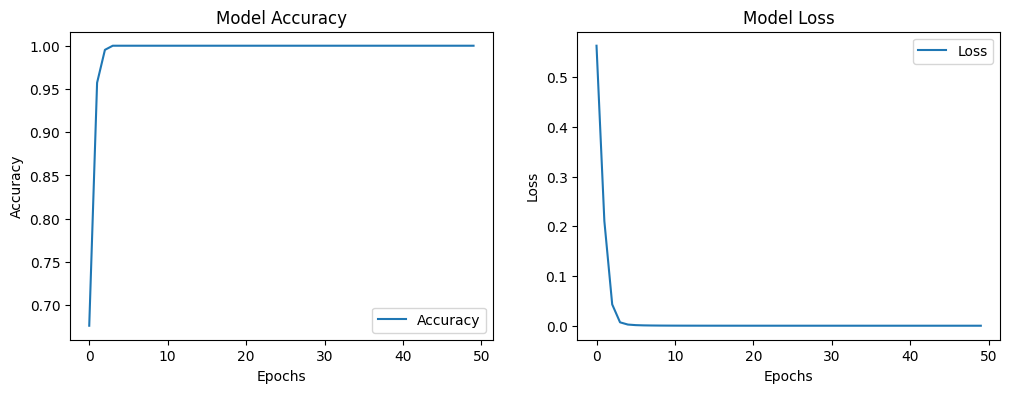

Model saved successfully at /content/drive/MyDrive/Models/Walvet_dec/ANN/Exp4/With_Stander.keras ✅


In [4]:
# Import necessary libraries
import os
import numpy as np
import pywt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
import matplotlib.pyplot as plt
import time  # Import time library for tracking the execution time

# Define a function to load the data from the directories
def load_data_from_directory(directory_path, label):
    data = []
    labels = []

    # Check if the directory exists
    if not os.path.exists(directory_path):
        print(f"Error: Directory {directory_path} not found.")
        return np.array([]), np.array([])

    # List all files in the directory, including .txt and .TXT files
    files = [f for f in os.listdir(directory_path) if f.lower().endswith('.txt')]  # Case-insensitive check for .txt and .TXT files

    # If no files found, return empty arrays
    if len(files) == 0:
        print(f"No .txt files found in {directory_path}.")
        return np.array([]), np.array([])

    # Load data from each file
    for filename in files:
        file_path = os.path.join(directory_path, filename)

        try:
            file_data = np.loadtxt(file_path)
            if file_data.ndim == 1:  # If 1D data, reshape to (n_samples, 1)
                file_data = file_data.reshape(-1, 1)

            # Apply wavelet decomposition with Daubechies 4 (db4) wavelet at level 5
            wavelet = 'db4'
            level = 5
            coeffs = pywt.wavedec(file_data.flatten(), wavelet, level=level)

            # Divide the coefficients: Low frequency (approximation) and High frequency (details)
            cA5, cD5, cD4, cD3, cD2, cD1 = coeffs  # Decomposed levels

            # Flatten coefficients into 1D arrays for each component
            low_freq = cA5.flatten()  # Approximation coefficients at level 5
            high_freq = np.hstack([cD5.flatten(), cD4.flatten(), cD3.flatten(), cD2.flatten(), cD1.flatten()])  # High frequency coefficients

            # Append low and high frequency features as separate channels
            data.append(np.hstack([low_freq, high_freq]))  # Concatenate low and high frequency features
            labels.append(label)

        except Exception as e:
            print(f"Error loading {filename}: {e}")

    # Convert to numpy arrays
    data = np.array(data, dtype=object)
    labels = np.array(labels)

    return data, labels

# Paths to your datasets (Z vs (S and N as same label))
path_Z = '/content/drive/My Drive/PFA2_DataSet/DataSet/Healthy/Z'  # Healthy (Z)
path_S = '/content/drive/My Drive/PFA2_DataSet/DataSet/Seizeur/S'  # Seizeur (S)
path_N = '/content/drive/My Drive/PFA2_DataSet/DataSet/Elipy/N'  # Epileptic (N)

# Step 1: Load data from the directories (Z vs S and N treated as the same label)
data_Z, labels_Z = load_data_from_directory(path_Z, label=0)  # Healthy (Z)
data_S, labels_S = load_data_from_directory(path_S, label=1)  # Seizeur (S)
data_N, labels_N = load_data_from_directory(path_N, label=1)  # Epileptic (N)

# Step 2: Concatenate data and labels from the three classes (Z vs S and N as same label)
if data_Z.size > 0 and data_S.size > 0 and data_N.size > 0:
    data_all = np.concatenate((data_Z, data_S, data_N), axis=0)
    labels_all = np.concatenate((labels_Z, labels_S, labels_N), axis=0)

    # Ensure the data is of type float32
    data_all = np.array(data_all, dtype=np.float32)

    # Step 3: One-hot encode the labels for Softmax activation (2 classes: Z vs S and N as same label)
    labels_all = to_categorical(labels_all, num_classes=2)  # One-hot encoding for 2 classes (Healthy and Non-Healthy)

    # Step 4: Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data_all, labels_all, test_size=0.3, random_state=42)

    # Step 5: Standardize the data using StandardScaler
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Step 6: Define the ANN model with Softmax in the output layer (2 classes)
    model = Sequential([
        Dense(512, input_dim=X_train.shape[1], activation='relu'),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(2, activation='softmax')  # Output layer for 2 classes (Healthy and Non-Healthy)
    ])

    # Compile the model with categorical crossentropy loss (for multi-class classification)
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

    # Step 7: Start time tracking
    start_time = time.time()

    # Step 8: Train the model and show training progress
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

    # Step 9: End time tracking
    end_time = time.time()
    training_time = end_time - start_time  # Time taken for training

    # Step 10: Evaluate the model on the test set
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)  # Get the index of the class with the highest probability

    # Step 11: Calculate evaluation metrics
    accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred_classes)
    recall = recall_score(np.argmax(y_test, axis=1), y_pred_classes, average='macro')
    precision = precision_score(np.argmax(y_test, axis=1), y_pred_classes, average='macro')
    conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), y_pred_classes)

    # Calculate sensitivity (recall) and specificity
    # Sensitivity (Recall for class 1: Non-Healthy)
    sensitivity = recall_score(np.argmax(y_test, axis=1), y_pred_classes, pos_label=1)

    # Specificity (Recall for class 0: Healthy)
    specificity = recall_score(np.argmax(y_test, axis=1), y_pred_classes, pos_label=0)

    # Step 12: Print evaluation metrics
    print("Training time: {:.2f} seconds".format(training_time))
    print("Accuracy: ", accuracy)
    print("Recall (Sensitivity): ", sensitivity)
    print("Precision: ", precision)
    print("Specificity: ", specificity)
    print("Confusion Matrix: \n", conf_matrix)

    # Step 13: Plot Training History
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

else:
    print("Error: Data loading failed. Ensure the files are present in the directories.")



       # Define the model path
model_path = "/content/drive/MyDrive/Models/Walvet_dec/ANN/Exp4/With_Stander.keras"

# Save the model
model.save(model_path)

print(f"Model saved successfully at {model_path} ✅")


with only optmizer


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.5756 - loss: 83.3522 - val_accuracy: 0.6778 - val_loss: 59.2582
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8093 - loss: 15.2741 - val_accuracy: 0.6111 - val_loss: 25.8082
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9337 - loss: 2.8154 - val_accuracy: 0.6556 - val_loss: 27.9133
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9498 - loss: 0.6458 - val_accuracy: 0.6889 - val_loss: 37.9080
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9472 - loss: 0.9659 - val_accuracy: 0.6222 - val_loss: 36.4795
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9848 - loss: 0.2113 - val_accuracy: 0.6556 - val_loss: 29.6654
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9820 - loss: 0.2621 - val_accuracy: 0.6111 - val_loss: 32.2621
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9951 - loss: 0.1068 - val_accuracy: 0.6000 - val_loss: 34.3979
E

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Training time: 14.34 seconds
Accuracy:  0.6222222222222222
Recall (Sensitivity):  0.9818181818181818
Precision:  0.6436781609195402
Specificity:  0.05714285714285714
Confusion Matrix: 
 [[ 2 33]
 [ 1 54]]


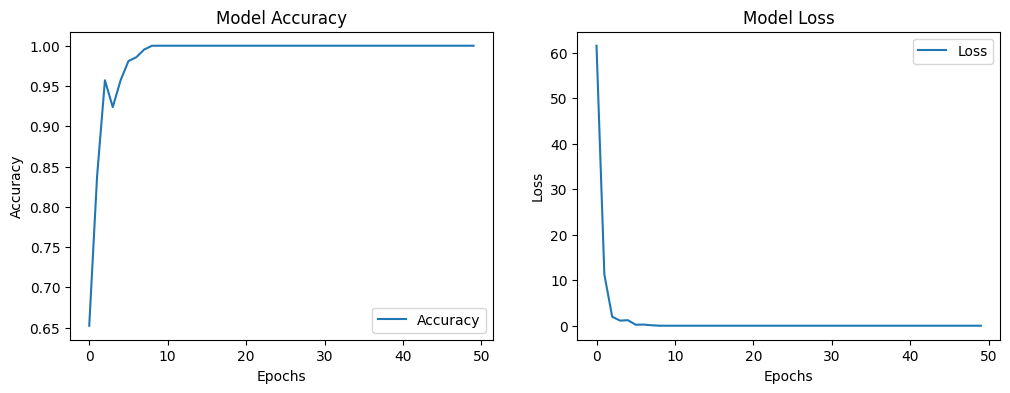

Model saved successfully at /content/drive/MyDrive/Models/Walvet_dec/ANN/Exp4/With_Optimiser.keras ✅


In [5]:
# Import necessary libraries
import os
import numpy as np
import pywt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
import matplotlib.pyplot as plt
import time  # Import time library for tracking the execution time
from tensorflow.keras.optimizers import Adam  # Import Adam optimizer

# Define a function to load the data from the directories
def load_data_from_directory(directory_path, label):
    data = []
    labels = []

    # Check if the directory exists
    if not os.path.exists(directory_path):
        print(f"Error: Directory {directory_path} not found.")
        return np.array([]), np.array([])

    # List all files in the directory, including .txt and .TXT files
    files = [f for f in os.listdir(directory_path) if f.lower().endswith('.txt')]  # Case-insensitive check for .txt and .TXT files

    # If no files found, return empty arrays
    if len(files) == 0:
        print(f"No .txt files found in {directory_path}.")
        return np.array([]), np.array([])

    # Load data from each file
    for filename in files:
        file_path = os.path.join(directory_path, filename)

        try:
            file_data = np.loadtxt(file_path)
            if file_data.ndim == 1:  # If 1D data, reshape to (n_samples, 1)
                file_data = file_data.reshape(-1, 1)

            # Apply wavelet decomposition with Daubechies 4 (db4) wavelet at level 5
            wavelet = 'db4'
            level = 5
            coeffs = pywt.wavedec(file_data.flatten(), wavelet, level=level)

            # Divide the coefficients: Low frequency (approximation) and High frequency (details)
            cA5, cD5, cD4, cD3, cD2, cD1 = coeffs  # Decomposed levels

            # Flatten coefficients into 1D arrays for each component
            low_freq = cA5.flatten()  # Approximation coefficients at level 5
            high_freq = np.hstack([cD5.flatten(), cD4.flatten(), cD3.flatten(), cD2.flatten(), cD1.flatten()])  # High frequency coefficients

            # Append low and high frequency features as separate channels
            data.append(np.hstack([low_freq, high_freq]))  # Concatenate low and high frequency features
            labels.append(label)

        except Exception as e:
            print(f"Error loading {filename}: {e}")

    # Convert to numpy arrays
    data = np.array(data, dtype=object)
    labels = np.array(labels)

    return data, labels

# Paths to your datasets (Z vs (S and N as same label))
path_Z = '/content/drive/My Drive/PFA2_DataSet/DataSet/Healthy/Z'  # Healthy (Z)
path_S = '/content/drive/My Drive/PFA2_DataSet/DataSet/Seizeur/S'  # Seizeur (S)
path_N = '/content/drive/My Drive/PFA2_DataSet/DataSet/Elipy/N'  # Epileptic (N)

# Step 1: Load data from the directories (Z vs S and N treated as the same label)
data_Z, labels_Z = load_data_from_directory(path_Z, label=0)  # Healthy (Z)
data_S, labels_S = load_data_from_directory(path_S, label=1)  # Seizeur (S)
data_N, labels_N = load_data_from_directory(path_N, label=1)  # Epileptic (N)

# Step 2: Concatenate data and labels from the three classes (Z vs S and N as same label)
if data_Z.size > 0 and data_S.size > 0 and data_N.size > 0:
    data_all = np.concatenate((data_Z, data_S, data_N), axis=0)
    labels_all = np.concatenate((labels_Z, labels_S, labels_N), axis=0)

    # Ensure the data is of type float32
    data_all = np.array(data_all, dtype=np.float32)

    # Step 3: One-hot encode the labels for Softmax activation (2 classes: Z vs S and N as same label)
    labels_all = to_categorical(labels_all, num_classes=2)  # One-hot encoding for 2 classes (Healthy and Non-Healthy)

    # Step 4: Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data_all, labels_all, test_size=0.3, random_state=42)

    # Step 5: Define the ANN model with Softmax in the output layer (2 classes)
    model = Sequential([
        Dense(512, input_dim=X_train.shape[1], activation='relu'),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(2, activation='softmax')  # Output layer for 2 classes (Healthy and Non-Healthy)
    ])

    # Compile the model with Adam optimizer and categorical crossentropy loss
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    # Step 6: Start time tracking
    start_time = time.time()

    # Step 7: Train the model and show training progress
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

    # Step 8: End time tracking
    end_time = time.time()
    training_time = end_time - start_time  # Time taken for training

    # Step 9: Evaluate the model on the test set
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)  # Get the index of the class with the highest probability

    # Step 10: Calculate evaluation metrics
    accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred_classes)
    recall = recall_score(np.argmax(y_test, axis=1), y_pred_classes, average='macro')
    precision = precision_score(np.argmax(y_test, axis=1), y_pred_classes, average='macro')
    conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), y_pred_classes)

    # Calculate sensitivity (recall) and specificity
    # Sensitivity (Recall for class 1: Non-Healthy)
    sensitivity = recall_score(np.argmax(y_test, axis=1), y_pred_classes, pos_label=1)

    # Specificity (Recall for class 0: Healthy)
    specificity = recall_score(np.argmax(y_test, axis=1), y_pred_classes, pos_label=0)

    # Step 11: Print evaluation metrics
    print("Training time: {:.2f} seconds".format(training_time))
    print("Accuracy: ", accuracy)
    print("Recall (Sensitivity): ", sensitivity)
    print("Precision: ", precision)
    print("Specificity: ", specificity)
    print("Confusion Matrix: \n", conf_matrix)

    # Step 12: Plot Training History
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

else:
    print("Error: Data loading failed. Ensure the files are present in the directories.")



      # Define the model path
model_path = "/content/drive/MyDrive/Models/Walvet_dec/ANN/Exp4/With_Optimiser.keras"

# Save the model
model.save(model_path)

print(f"Model saved successfully at {model_path} ✅")



both Adam optimizer and StandardScaler

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.5876 - loss: 0.7824 - val_accuracy: 0.5556 - val_loss: 0.5900
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9137 - loss: 0.3015 - val_accuracy: 0.6333 - val_loss: 0.6521
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9844 - loss: 0.1051 - val_accuracy: 0.6667 - val_loss: 0.7006
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 0.0274 - val_accuracy: 0.6889 - val_loss: 0.7734
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 1.0000 - loss: 0.0072 - val_accuracy: 0.6333 - val_loss: 1.3484
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 1.0000 - loss: 0.0023 - val_accuracy: 0.6444 - val_loss: 1.5099
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 1.0000 - loss: 7.4334e-04 - val_accuracy: 0.6778 - val_loss: 1.4464
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 2.5068e-04 - val_accuracy: 0.6778 - val_loss: 1.4012
Epo

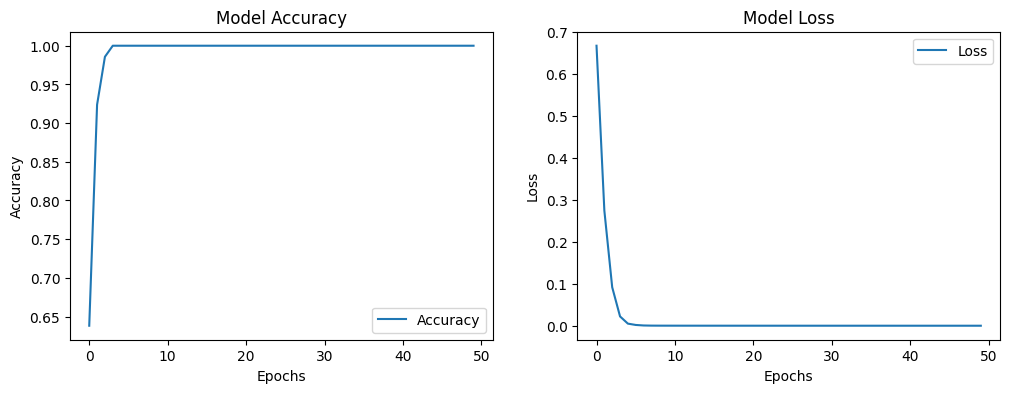

Model saved successfully at /content/drive/MyDrive/Models/Walvet_dec/ANN/Exp4/With_Options.keras ✅


In [6]:
# Import necessary libraries
import os
import numpy as np
import pywt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
import matplotlib.pyplot as plt
import time  # Import time library for tracking the execution time
from tensorflow.keras.optimizers import Adam  # Import Adam optimizer
from sklearn.preprocessing import StandardScaler  # Import StandardScaler for feature scaling

# Define a function to load the data from the directories
def load_data_from_directory(directory_path, label):
    data = []
    labels = []

    # Check if the directory exists
    if not os.path.exists(directory_path):
        print(f"Error: Directory {directory_path} not found.")
        return np.array([]), np.array([])

    # List all files in the directory, including .txt and .TXT files
    files = [f for f in os.listdir(directory_path) if f.lower().endswith('.txt')]  # Case-insensitive check for .txt and .TXT files

    # If no files found, return empty arrays
    if len(files) == 0:
        print(f"No .txt files found in {directory_path}.")
        return np.array([]), np.array([])

    # Load data from each file
    for filename in files:
        file_path = os.path.join(directory_path, filename)

        try:
            file_data = np.loadtxt(file_path)
            if file_data.ndim == 1:  # If 1D data, reshape to (n_samples, 1)
                file_data = file_data.reshape(-1, 1)

            # Apply wavelet decomposition with Daubechies 4 (db4) wavelet at level 5
            wavelet = 'db4'
            level = 5
            coeffs = pywt.wavedec(file_data.flatten(), wavelet, level=level)

            # Divide the coefficients: Low frequency (approximation) and High frequency (details)
            cA5, cD5, cD4, cD3, cD2, cD1 = coeffs  # Decomposed levels

            # Flatten coefficients into 1D arrays for each component
            low_freq = cA5.flatten()  # Approximation coefficients at level 5
            high_freq = np.hstack([cD5.flatten(), cD4.flatten(), cD3.flatten(), cD2.flatten(), cD1.flatten()])  # High frequency coefficients

            # Append low and high frequency features as separate channels
            data.append(np.hstack([low_freq, high_freq]))  # Concatenate low and high frequency features
            labels.append(label)

        except Exception as e:
            print(f"Error loading {filename}: {e}")

    # Convert to numpy arrays
    data = np.array(data, dtype=object)
    labels = np.array(labels)

    return data, labels

# Paths to your datasets (Z vs (S and N as same label))
path_Z = '/content/drive/My Drive/PFA2_DataSet/DataSet/Healthy/Z'  # Healthy (Z)
path_S = '/content/drive/My Drive/PFA2_DataSet/DataSet/Seizeur/S'  # Seizeur (S)
path_N = '/content/drive/My Drive/PFA2_DataSet/DataSet/Elipy/N'  # Epileptic (N)

# Step 1: Load data from the directories (Z vs S and N treated as the same label)
data_Z, labels_Z = load_data_from_directory(path_Z, label=0)  # Healthy (Z)
data_S, labels_S = load_data_from_directory(path_S, label=1)  # Seizeur (S)
data_N, labels_N = load_data_from_directory(path_N, label=1)  # Epileptic (N)

# Step 2: Concatenate data and labels from the three classes (Z vs S and N as same label)
if data_Z.size > 0 and data_S.size > 0 and data_N.size > 0:
    data_all = np.concatenate((data_Z, data_S, data_N), axis=0)
    labels_all = np.concatenate((labels_Z, labels_S, labels_N), axis=0)

    # Ensure the data is of type float32
    data_all = np.array(data_all, dtype=np.float32)

    # Step 3: One-hot encode the labels for Softmax activation (2 classes: Z vs S and N as same label)
    labels_all = to_categorical(labels_all, num_classes=2)  # One-hot encoding for 2 classes (Healthy and Non-Healthy)

    # Step 4: Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data_all, labels_all, test_size=0.3, random_state=42)

    # Step 5: Standardize the features using StandardScaler
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Step 6: Define the ANN model with Softmax in the output layer (2 classes)
    model = Sequential([
        Dense(512, input_dim=X_train.shape[1], activation='relu'),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(2, activation='softmax')  # Output layer for 2 classes (Healthy and Non-Healthy)
    ])

    # Compile the model with Adam optimizer and categorical crossentropy loss
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    # Step 7: Start time tracking
    start_time = time.time()

    # Step 8: Train the model and show training progress
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

    # Step 9: End time tracking
    end_time = time.time()
    training_time = end_time - start_time  # Time taken for training

    # Step 10: Evaluate the model on the test set
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)  # Get the index of the class with the highest probability

    # Step 11: Calculate evaluation metrics
    accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred_classes)
    recall = recall_score(np.argmax(y_test, axis=1), y_pred_classes, average='macro')
    precision = precision_score(np.argmax(y_test, axis=1), y_pred_classes, average='macro')
    conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), y_pred_classes)

    # Calculate sensitivity (recall) and specificity
    # Sensitivity (Recall for class 1: Non-Healthy)
    sensitivity = recall_score(np.argmax(y_test, axis=1), y_pred_classes, pos_label=1)

    # Specificity (Recall for class 0: Healthy)
    specificity = recall_score(np.argmax(y_test, axis=1), y_pred_classes, pos_label=0)

    # Step 12: Print evaluation metrics
    print("Training time: {:.2f} seconds".format(training_time))
    print("Accuracy: ", accuracy)
    print("Recall (Sensitivity): ", sensitivity)
    print("Precision: ", precision)
    print("Specificity: ", specificity)
    print("Confusion Matrix: \n", conf_matrix)

    # Step 13: Plot Training History
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

else:
    print("Error: Data loading failed. Ensure the files are present in the directories.")


           # Define the model path
model_path = "/content/drive/MyDrive/Models/Walvet_dec/ANN/Exp4/With_Options.keras"

# Save the model
model.save(model_path)

print(f"Model saved successfully at {model_path} ✅")
